In [2]:
import pyrealsense2 as rs
import numpy as np
import cv2
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

/home/credit-research2/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Image Classification Demo

#### Load Dataset

In [3]:
dataset = load_dataset("Cifar10")
dataset.set_format(type = "torch")

#### Train Model

In [4]:
class Cifar10_model(torch.nn.Module):

    def __init__(self, classes = 10):
        super(Cifar10_model, self).__init__()
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.classes = 10

        self.conv0 = torch.nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1)
        self.batch_norm_0 = torch.nn.BatchNorm2d(32)
        self.max_pool_0 = torch.nn.MaxPool2d(kernel_size = 2)
        
        self.conv1 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1)
        self.batch_norm_1 = torch.nn.BatchNorm2d(64)
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size = 2)

        self.conv2 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding = 1)
        self.batch_norm_2 = torch.nn.BatchNorm2d(128)
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size = 2)
        
        self.linear0 = torch.nn.Linear(2048, 512)
        self.linear1 = torch.nn.Linear(512, 10)
        
        self.Relu = torch.nn.ReLU()
        self.linear_dropout = torch.nn.Dropout(0.1)
    
    def forward(self, images, labels = None):
        
        logits = self.conv0(images)
        logits = self.batch_norm_0(logits)
        logits = self.Relu(logits)
        logits = self.max_pool_0(logits)

        logits = self.conv1(logits)
        logits = self.batch_norm_1(logits)
        logits = self.Relu(logits)
        logits = self.max_pool_1(logits)

        logits = self.conv2(logits)
        logits = self.batch_norm_2(logits)
        logits = self.Relu(logits)
        logits = self.max_pool_2(logits)

        logits = logits.flatten(1)

        logits = self.linear0(logits)
        logits = self.Relu(logits)
        logits = self.linear_dropout(logits)

        logits = self.linear1(logits)


        if self.training:
            logits = logits.reshape(-1, self.classes).cpu()
            loss = self.loss_fn(logits, labels)
            return logits, loss
        else: return logits

    def predict(self, image):
        logits = self(images = image);
        probs = torch.nn.functional.softmax(logits, dim = -1)
        return probs
        


        

In [5]:
def train(model = None, dataset = None, steps = 1000, lr = 0.001, batch_sz = 128,device = "cuda"):
    history = {"Avg_loss":[], "loss":[]}
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model = model.to(device)
    
    for i in tqdm(range(steps)):
        batch = dataset["train"].shuffle().select(range(batch_sz))
        images, labels = batch[:]["img"].type(torch.float), batch[:]["label"]

        optimizer.zero_grad()
        
        logits, loss = model(images = images.to(device), labels = labels)
        loss.backward()
        optimizer.step()

        if i%100 == 0:
            print(f"loss: {loss.item()}")
            model.eval()
            with torch.no_grad():
                val_batch = dataset["test"].shuffle().select(range(2000))
                images = val_batch[:]["img"].type(torch.float)
                probs = model(images.to(device))
                preds = torch.argmax(probs, dim = -1)
                preds = preds.flatten().cpu().numpy()
                labels = val_batch[:]["label"].flatten().numpy()

                accuracy = accuracy_score(preds, labels)
                print(f"val accuracy:{accuracy}")
            model.train()
                
            
    return model


            

In [6]:
model = Cifar10_model()
model = train(model, dataset, batch_sz = 256, lr = 0.005, steps = 2000)

  0%|                                                  | 0/2000 [00:00<?, ?it/s]/home/credit-research2/miniconda3/lib/python3.13/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


loss: 2.34138822555542


  0%|                                          | 3/2000 [00:01<10:44,  3.10it/s]

val accuracy:0.102


  5%|██                                       | 99/2000 [00:07<02:03, 15.42it/s]

loss: 1.7540053129196167


  5%|██                                      | 103/2000 [00:08<03:14,  9.75it/s]

val accuracy:0.3735


 10%|███▉                                    | 199/2000 [00:14<02:09, 13.92it/s]

loss: 1.4852335453033447


 10%|████                                    | 203/2000 [00:15<03:12,  9.33it/s]

val accuracy:0.4805


 15%|█████▉                                  | 299/2000 [00:22<01:57, 14.42it/s]

loss: 1.2800681591033936


 15%|██████                                  | 303/2000 [00:22<03:04,  9.18it/s]

val accuracy:0.5155


 20%|███████▉                                | 399/2000 [00:29<01:39, 16.12it/s]

loss: 1.1658517122268677


 20%|████████                                | 403/2000 [00:30<02:41,  9.91it/s]

val accuracy:0.5645


 25%|█████████▉                              | 499/2000 [00:36<01:35, 15.66it/s]

loss: 1.1712384223937988


 25%|██████████                              | 503/2000 [00:37<02:32,  9.84it/s]

val accuracy:0.603


 30%|███████████▉                            | 599/2000 [00:44<01:38, 14.18it/s]

loss: 0.9418813586235046


 30%|████████████                            | 603/2000 [00:44<02:26,  9.52it/s]

val accuracy:0.646


 35%|█████████████▉                          | 699/2000 [00:52<01:50, 11.74it/s]

loss: 0.9470316171646118


 35%|██████████████                          | 703/2000 [00:52<02:56,  7.36it/s]

val accuracy:0.633


 40%|███████████████▉                        | 799/2000 [00:59<01:20, 14.93it/s]

loss: 0.9492303729057312


 40%|████████████████                        | 803/2000 [01:00<02:01,  9.82it/s]

val accuracy:0.6675


 45%|█████████████████▉                      | 899/2000 [01:06<01:10, 15.62it/s]

loss: 0.7800306081771851


 45%|██████████████████                      | 903/2000 [01:07<01:48, 10.15it/s]

val accuracy:0.6765


 50%|███████████████████▉                    | 999/2000 [01:14<01:08, 14.71it/s]

loss: 0.8233806490898132


 50%|███████████████████▌                   | 1003/2000 [01:14<01:49,  9.12it/s]

val accuracy:0.685


 55%|█████████████████████▍                 | 1099/2000 [01:21<01:08, 13.19it/s]

loss: 0.7115017175674438


 55%|█████████████████████▌                 | 1103/2000 [01:22<01:36,  9.33it/s]

val accuracy:0.6325


 60%|███████████████████████▍               | 1199/2000 [01:28<00:50, 15.89it/s]

loss: 0.7878534197807312


 60%|███████████████████████▍               | 1203/2000 [01:28<01:16, 10.36it/s]

val accuracy:0.6865


 65%|█████████████████████████▎             | 1299/2000 [01:35<00:44, 15.84it/s]

loss: 0.6217015385627747


 65%|█████████████████████████▍             | 1303/2000 [01:35<01:07, 10.26it/s]

val accuracy:0.6575


 70%|███████████████████████████▎           | 1399/2000 [01:41<00:39, 15.30it/s]

loss: 0.632838785648346


 70%|███████████████████████████▎           | 1403/2000 [01:42<00:58, 10.14it/s]

val accuracy:0.7125


 75%|█████████████████████████████▏         | 1499/2000 [01:49<00:32, 15.31it/s]

loss: 0.6295556426048279


 75%|█████████████████████████████▎         | 1503/2000 [01:50<00:52,  9.52it/s]

val accuracy:0.7365


 80%|███████████████████████████████▏       | 1599/2000 [01:57<00:30, 13.29it/s]

loss: 0.5745267868041992


 80%|███████████████████████████████▎       | 1603/2000 [01:57<00:44,  8.85it/s]

val accuracy:0.6305


 85%|█████████████████████████████████▏     | 1699/2000 [02:04<00:20, 14.97it/s]

loss: 0.4692143201828003


 85%|█████████████████████████████████▏     | 1703/2000 [02:05<00:30,  9.83it/s]

val accuracy:0.606


 90%|███████████████████████████████████    | 1799/2000 [02:11<00:14, 14.06it/s]

loss: 0.5378811359405518


 90%|███████████████████████████████████▏   | 1803/2000 [02:12<00:20,  9.82it/s]

val accuracy:0.7175


 95%|█████████████████████████████████████  | 1899/2000 [02:19<00:07, 13.86it/s]

loss: 0.3895617723464966


 95%|█████████████████████████████████████  | 1903/2000 [02:19<00:09,  9.76it/s]

val accuracy:0.7585


100%|███████████████████████████████████████| 2000/2000 [02:25<00:00, 13.70it/s]


#### Calibrate Model with Conformal Prediction

In [8]:
import matplotlib.pyplot as plt
class Calibrator:
    cifar10_classes = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
    def __init__(self, model, device = "cuda"):
        self.model = model
        self.device = device
        self.conf_thresh = None

    def conformal_calibrate(self, dataset, alpha = 0.10, batch_sz = 256, n_examples = 5000):
        self.model.eval()
        self.model.to(self.device)
        model_steps = n_examples//batch_sz

        y_true_probs_dist = []
        for i in tqdm(range(model_steps)):
            batch = dataset["test"].shuffle().select(range(batch_sz))
            images, labels = batch[:]["img"].type(torch.float), batch[:]["label"]
            images.to(self.device)

            probs = self.model.predict(images)
            y_probs_true = probs[torch.arange(probs.shape[0]), labels.flatten()]

            y_true_probs_dist.extend(y_probs_true.detach().cpu().numpy().tolist())
        
        y_true_probs_dist = np.array(y_true_probs_dist)

        
        q_level =  np.ceil((y_true_probs_dist.shape[0]+1)*(1-alpha))/y_true_probs_dist.shape[0];
        qhat = np.quantile(1 - y_true_probs_dist, q_level, axis = 0, method = "higher");
        
        plt.hist(y_true_probs_dist, bins = 50)
        plt.axvline(x= 1-qhat, ls = "--", label = f"confidence threshold={1 - qhat}")
        plt.xlabel("count")
        plt.ylabel("confidence")
        plt.legend()
        plt.show()
        
        self.conf_thresh = 1 - qhat
        return 1 - qhat

    def predict(self, images):

        self.model.eval()
        self.model.to(self.device)

        images = torch.tensor(images)

        probs = self.model.predict(images)
        probs = probs.detach().cpu().numpy()

        probs_set = []
        class_set = []
        for i in range(probs.shape[0]):
            probs_i = probs[i]
            bool_keep = probs_i > self.conf_thresh
            classes_keep = self.cifar10_classes[bool_keep]
            probs_keep = probs_i[bool_keep]

            class_set.append(classes_keep)
            probs_set.append(probs_keep)


        return class_set, probs_set;
            

        

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 24.25it/s]


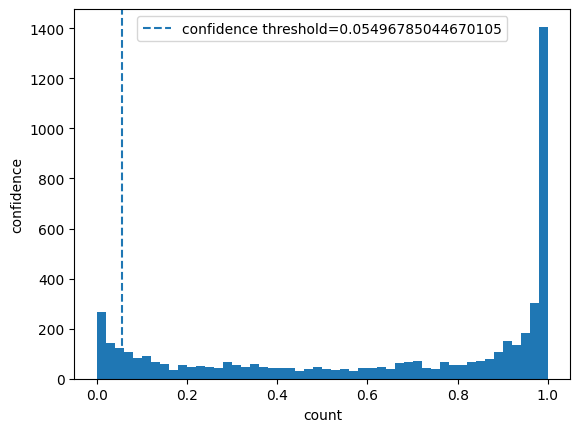

0.05496785044670105


In [9]:
calib_model = Calibrator(model, device = "cpu")
qhat = calib_model.conformal_calibrate(dataset = dataset, batch_sz = 100, alpha = 0.10)
print(qhat)

#### Test calibrated model on test image

frog


/tmp/ipykernel_19631/637042489.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)


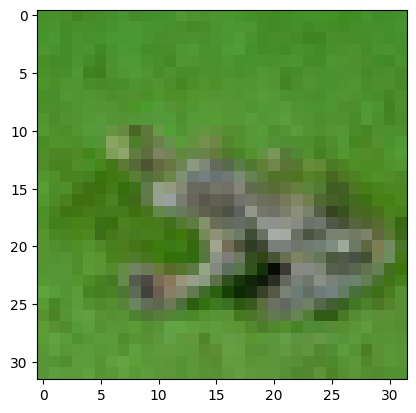

[array(['frog'], dtype='<U10')]
[array([0.93223155], dtype=float32)]


In [10]:
test_im = dataset["test"].shuffle().select(range(1))
images, labels = test_im[:]["img"].type(torch.float), test_im[:]["label"]

preds_set, probs_set = calib_model.predict(images)

print(calib_model.cifar10_classes[labels])
plt.imshow(np.array(test_im[:]["img"][0]).transpose(1, 2, 0))
plt.show()

print(preds_set)
print(probs_set)

#### Real-Time inference requires Intel RealSense Camera 

In [10]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Enable streams
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# Start streaming
pipeline.start(config)

try:
    i = 0
    while True:
        # Wait for a coherent pair of frames
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            continue

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        color_image_ = cv2.resize(color_image, (32, 32))

        if i%4 == 0:
            preds_set, probs_set = calib_model.predict(torch.tensor(color_image_).permute(2, 0, 1).type(torch.float).unsqueeze(0))

        text = f"class set:{preds_set[0].tolist()}"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        color = (255, 0, 0)   # Blue in BGR
        thickness = 2

        # Get image shape
        (h, w) = color_image.shape[:2]

        # Get text size
        (text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, thickness)

        # Position for top-right corner
        x = w - text_w - 10   
        y = text_h + 10       

        # Draw text
        cv2.putText(color_image, text, (x, y), font, font_scale, color, thickness)
        
        cv2.imshow('CP Image Classification', color_image)
        if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
            break

        if i == 100: i = 0
        else: i += 1;
finally:
    pipeline.stop()
    cv2.destroyAllWindows()


/tmp/ipykernel_44132/1725206503.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images)


In [6]:
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor
from PIL import Image
import requests

In [7]:
# Example: RT-DETRv2 with ResNet-18 backbone (trained on COCO/Object365)
#model_name = "PekingU/rtdetr_v2_r18vd"  
model_name = "PekingU/rtdetr_v2_r50vd"
#model_name = "PekingU/rtdetr_r50vd_coco_o365"
# Load model and image processor
processor = RTDetrImageProcessor.from_pretrained(model_name)
model = RTDetrForObjectDetection.from_pretrained(model_name)
model.eval();

Fetching 1 files: 100%|█████████████████████████| 1/1 [00:00<00:00, 8160.12it/s]
You are using a model of type rt_detr_v2 to instantiate a model of type rt_detr. This is not supported for all configurations of models and can yield errors.


In [8]:
from datasets import load_dataset
coco_dataset = load_dataset("coco2017", data_dir = "val2017")

(427, 640, 3)


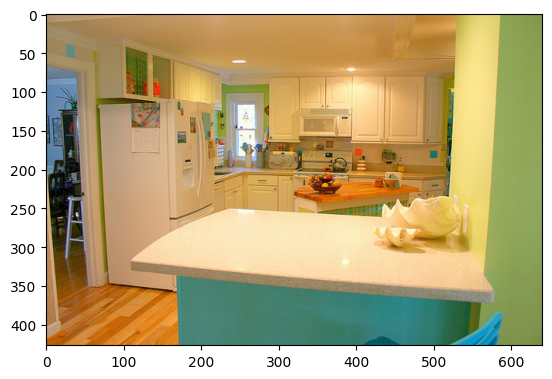

In [32]:
from PIL import Image
image_dir = "coco2017/val2017/"
image_id = list(parsed_ann.keys())[22] 
path = image_dir + image_id + ".jpg"
image = np.array(Image.open(path))
print(image.shape)
plt.imshow(image)
plt.show()


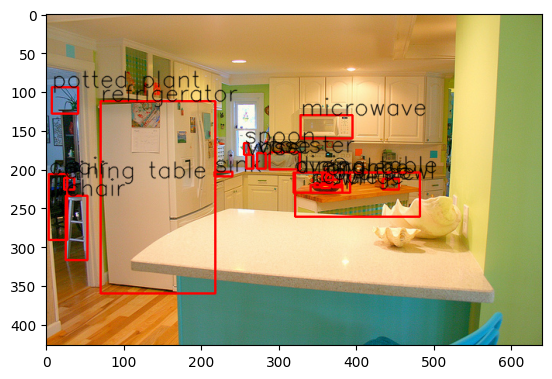

In [16]:
import json
from PIL import Image

def parse_coco_ann(ann_path):
    with open(ann_path) as f:
        ann = json.load(f)
    zero_str = "000000000000"
    parsed_ann = {}
    for ann_ in ann["annotations"]:
        image_id = ann_["image_id"]
        image_id = zero_str[:12 - len(str(image_id))] + str(image_id)
        #bbox is x_min, y_min, w, h
        bbox_x1 = ann_["bbox"][0]
        bbox_y1 = ann_["bbox"][1]
        bbox_x2 = ann_["bbox"][0] + ann_["bbox"][2]
        bbox_y2 = ann_["bbox"][1] + ann_["bbox"][3]
        bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
        cat = ann_["category_id"]
        if image_id in parsed_ann.keys():
            parsed_ann[image_id]["bbox"].append(np.array(bbox))
            parsed_ann[image_id]["class"].append(coco_id_to_name[cat])
        else:
            parsed_ann[image_id] = {"bbox":[np.array(bbox)], "class":[coco_id_to_name[cat]]}

    return parsed_ann;

def plot_objects(image, bbox, object_class, display = True):
    """
    image should be np.array with shape(h, w, c)
    bbox shoule be x1, y1, x2, y2 as np array with shape (N, 4)
    """
    for i in range(len(bbox)):
        bbox_ = bbox[i]
        object_class_ = object_class[i]

        start_pt = (np.ceil(bbox_[0]).astype(int), np.ceil(bbox_[1]).astype(int))
        end_pt = (np.ceil(bbox_[2]).astype(int), np.ceil(bbox_[3]).astype(int))
        cv2.rectangle(image, start_pt, end_pt, color = (255, 0, 0), thickness = 2)
        cv2.putText(image,text = object_class_, org=(np.ceil(bbox_[0]).astype(int), np.ceil(bbox_[1]).astype(int)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    plt.imshow(image)
    plt.show()
        
image_dir = "coco2017/val2017/"
ann_path = "coco2017/annotations/instances_val2017.json"
parsed_ann = parse_coco_ann(ann_path)
image_id = list(parsed_ann.keys())[22]
#print(parsed_ann[image_id].keys())
image_path = image_dir + image_id + ".jpg"
image = np.array(Image.open(image_path))    
plot_objects(image, bbox = parsed_ann[image_id]["bbox"], object_class = parsed_ann[image_id]["class"])

(480, 640, 3)


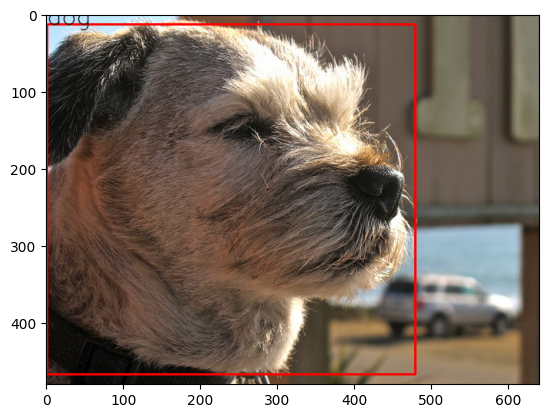

In [59]:
image_dir = "coco2017/val2017/"
ann_path = "coco2017/annotations/instances_val2017.json"
parsed_ann = parse_coco_ann(ann_path)
image_id = list(parsed_ann.keys())[14]
image_path = image_dir + image_id + ".jpg"
image = np.array(Image.open(image_path))    
#image = cv2.resize(image, (640, 640))

conf_thresh = 0.90
model_in = processor(images = image, return_tensors="pt", do_resize = False)
model_out = model(**model_in)
probs = model_out.logits.softmax(-1)
probs_preds = torch.max(probs, dim = -1)[0]
preds_keep = probs_preds > conf_thresh
class_preds = torch.argmax(probs, dim = -1)
im_w = image.shape[1]
im_h = image.shape[0]
#bbox is [cx_norm, cy_norm, w_norm, h_norm]
bbox_preds = model_out.pred_boxes[0]
bbox_preds[:, 0] = bbox_preds[:, 0]*im_w 
bbox_preds[:, 1] = bbox_preds[:, 1]*im_h 
bbox_preds[:, 2] = bbox_preds[:, 2]*im_w 
bbox_preds[:, 3] = bbox_preds[:, 3]*im_h
bbox_x1 = bbox_preds[:, 0] - bbox_preds[:, 2]//2
bbox_x2 = bbox_preds[:, 0] + bbox_preds[:, 2]//2
bbox_y1 = bbox_preds[:, 1] - bbox_preds[:, 3]//2
bbox_y2 = bbox_preds[:, 1] + bbox_preds[:, 3]//2

bbox_preds = torch.stack([bbox_x1, bbox_y1, bbox_x2, bbox_y2], dim = -1).detach().cpu().numpy()
class_preds = [rtdetr_id_to_name[class_]  for class_ in class_preds[preds_keep].detach().cpu().numpy()] 
print(image.shape)
plot_objects(image, bbox = bbox_preds[preds_keep.flatten()], object_class = class_preds)


In [9]:
rtdetr_id_to_name = {
     0: "person",       1: "bicycle",      2: "car",          3: "motorcycle",
     4: "airplane",     5: "bus",          6: "train",        7: "truck",
     8: "boat",         9: "traffic light",10: "fire hydrant",11: "stop sign",
    12: "parking meter",13: "bench",       14: "bird",        15: "cat",
    16: "dog",         17: "horse",       18: "sheep",       19: "cow",
    20: "elephant",    21: "bear",        22: "zebra",       23: "giraffe",
    24: "backpack",    25: "umbrella",    26: "handbag",     27: "tie",
    28: "suitcase",    29: "frisbee",     30: "skis",        31: "snowboard",
    32: "sports ball", 33: "kite",        34: "baseball bat",35: "baseball glove",
    36: "skateboard",  37: "surfboard",   38: "tennis racket",39: "bottle",
    40: "wine glass",  41: "cup",         42: "fork",        43: "knife",
    44: "spoon",       45: "bowl",        46: "banana",      47: "apple",
    48: "sandwich",    49: "orange",      50: "broccoli",    51: "carrot",
    52: "hot dog",     53: "pizza",       54: "donut",       55: "cake",
    56: "chair",       57: "couch",       58: "potted plant",59: "bed",
    60: "dining table",61: "toilet",      62: "tv",          63: "laptop",
    64: "mouse",       65: "remote",      66: "keyboard",    67: "cell phone",
    68: "microwave",   69: "oven",        70: "toaster",     71: "sink",
    72: "refrigerator",73: "book",        74: "clock",       75: "vase",
    76: "scissors",    77: "teddy bear",  78: "hair drier",  79: "toothbrush"
}

In [10]:
coco_id_to_name = {
     1: "person",        2: "bicycle",       3: "car",           4: "motorcycle",
     5: "airplane",      6: "bus",           7: "train",         8: "truck",
     9: "boat",         10: "traffic light",11: "fire hydrant", 13: "stop sign",
    14: "parking meter",15: "bench",        16: "bird",         17: "cat",
    18: "dog",          19: "horse",        20: "sheep",        21: "cow",
    22: "elephant",     23: "bear",         24: "zebra",        25: "giraffe",
    27: "backpack",     28: "umbrella",     31: "handbag",      32: "tie",
    33: "suitcase",     34: "frisbee",      35: "skis",         36: "snowboard",
    37: "sports ball",  38: "kite",         39: "baseball bat", 40: "baseball glove",
    41: "skateboard",   42: "surfboard",    43: "tennis racket",44: "bottle",
    46: "wine glass",   47: "cup",          48: "fork",         49: "knife",
    50: "spoon",        51: "bowl",         52: "banana",       53: "apple",
    54: "sandwich",     55: "orange",       56: "broccoli",     57: "carrot",
    58: "hot dog",      59: "pizza",        60: "donut",        61: "cake",
    62: "chair",        63: "couch",        64: "potted plant", 65: "bed",
    67: "dining table", 70: "toilet",       72: "tv",           73: "laptop",
    74: "mouse",        75: "remote",       76: "keyboard",     77: "cell phone",
    78: "microwave",    79: "oven",         80: "toaster",      81: "sink",
    82: "refrigerator", 84: "book",         85: "clock",        86: "vase",
    87: "scissors",     88: "teddy bear",   89: "hair drier",   90: "toothbrush"
}


In [11]:
import matplotlib.pyplot as plt
from ultralytics.utils.metrics import box_iou
import random
import json
class OD_Calibrator:
    coco_ids = coco_id_to_name
    model_ids = rtdetr_id_to_name
    def __init__(self, model = None, processor = None, device = "cuda"):
        self.model = model
        self.processor = processor
        self.device = device
        self.conf_thresh = None

    def parse_coco_ann(self, ann_path):
        with open(ann_path) as f:
            ann = json.load(f)
        zero_str = "000000000000"
        parsed_ann = {}
        for ann_ in ann["annotations"]:
            image_id = ann_["image_id"]
            image_id = zero_str[:12 - len(str(image_id))] + str(image_id)
            #bbox is x_min, y_min, w, h
            bbox_x1 = ann_["bbox"][0]
            bbox_y1 = ann_["bbox"][1]
            bbox_x2 = ann_["bbox"][0] + ann_["bbox"][2]
            bbox_y2 = ann_["bbox"][1] + ann_["bbox"][3]
            bbox = [bbox_x1, bbox_y1, bbox_x2, bbox_y2]
            cat = ann_["category_id"]
            if image_id in parsed_ann.keys():
                parsed_ann[image_id]["bbox"].append(np.array(bbox))
                parsed_ann[image_id]["class"].append(coco_id_to_name[cat])
                parsed_ann[image_id]["coco_id"].append(cat)
            else:
                parsed_ann[image_id] = {"bbox":[np.array(bbox)], "class":[coco_id_to_name[cat]], "coco_id":[cat]}

        return parsed_ann;
    
    
    def conformal_calibrate(self, ann_path = "", image_dir = "", alpha = 0.10, batch_sz = 256, n_images = 5000, iou_thresh = 0.50):
        """
        
        """
        
        self.model.eval()
        self.model.to(self.device)
        #model_steps = n_examples//batch_sz
        
        y_true_probs_dist = []

        parsed_ann = self.parse_coco_ann(ann_path)
        image_ids = random.sample(list(parsed_ann.keys()), n_images)
        for image_id in tqdm(image_ids):

            bbox_true = parsed_ann[image_id]["bbox"]
            class_id_true = parsed_ann[image_id]["coco_id"]
        
            image_path = image_dir + image_id + ".jpg"
            image = np.array(Image.open(image_path))   
            im_w = image.shape[1]
            im_h = image.shape[0]
    
            model_in = self.processor(images = image, return_tensors="pt")#, do_resize = False)
            model_out = self.model(**model_in.to(self.device))
            
            probs = model_out.logits.softmax(-1).detach().cpu().numpy().reshape(-1, 80)

            bbox_preds = model_out.pred_boxes[0]
            bbox_preds[:, 0] = bbox_preds[:, 0]*im_w 
            bbox_preds[:, 1] = bbox_preds[:, 1]*im_h 
            bbox_preds[:, 2] = bbox_preds[:, 2]*im_w 
            bbox_preds[:, 3] = bbox_preds[:, 3]*im_h
            bbox_x1 = bbox_preds[:, 0] - bbox_preds[:, 2]//2
            bbox_x2 = bbox_preds[:, 0] + bbox_preds[:, 2]//2
            bbox_y1 = bbox_preds[:, 1] - bbox_preds[:, 3]//2
            bbox_y2 = bbox_preds[:, 1] + bbox_preds[:, 3]//2
            bbox_preds = torch.stack([bbox_x1, bbox_y1, bbox_x2, bbox_y2], dim = -1).detach().cpu()


            #shape is (n_preds, n_true)
            iou_mat = box_iou(bbox_preds, torch.tensor(bbox_true))
            #filter iou matrix to predictions that are over iou threshold
            iou_mat = iou_mat >= iou_thresh
            #iou_mat = (iou_mat < iou_thresh)&(iou_mat > 0)
            #iou_mat = iou_mat == 0
            iou_bool = torch.sum(iou_mat, dim = -1).type(torch.bool)
    
            iou_mat = iou_mat[iou_bool, :]
        

            model_class_ids, coco_class_names = np.array(list(self.model_ids.items())).transpose()
            
            #loop through each prediction
            for i in range(iou_mat.shape[0]):
                #loop through each groundtruth
                iou_vec = iou_mat[i, :]
                for n in range(iou_mat.shape[1]):
                    iou_val = iou_vec[n]
                    if iou_val.type(torch.bool):
                        true_class_model_id = model_class_ids[self.coco_ids[class_id_true[n]] == coco_class_names]
                        prob_true_class = probs[i, int(true_class_model_id)]
                        y_true_probs_dist.append(prob_true_class)
        
        y_true_probs_dist = np.array(y_true_probs_dist)

        
        q_level =  np.ceil((y_true_probs_dist.shape[0]+1)*(1-alpha))/y_true_probs_dist.shape[0];
        qhat = np.quantile(1 - y_true_probs_dist, q_level, axis = 0, method = "higher");
        
        plt.hist(y_true_probs_dist, bins = 50)
        plt.axvline(x= 1-qhat, ls = "--", label = f"confidence threshold={1 - qhat}")
        plt.legend()
        plt.show()
        print(f"samples = {y_true_probs_dist.shape[0]}")
        self.conf_thresh = 1 - qhat
        return 1 - qhat

    def predict(self, image = None, max_set_size = 3):

        self.model.eval()
        self.model.to(self.device)

        probs_set = []
        class_set = []
        bbox_set = []
        set_size = []

        im_w = image.shape[1]
        im_h = image.shape[0]
    
        model_in = self.processor(images = image, return_tensors="pt")#, do_resize = False)
        model_out = self.model(**model_in.to(self.device))
            
        probs = model_out.logits.softmax(-1).detach().cpu().numpy().reshape(-1, 80)

        bbox_preds = model_out.pred_boxes[0]
        bbox_preds[:, 0] = bbox_preds[:, 0]*im_w 
        bbox_preds[:, 1] = bbox_preds[:, 1]*im_h 
        bbox_preds[:, 2] = bbox_preds[:, 2]*im_w 
        bbox_preds[:, 3] = bbox_preds[:, 3]*im_h
        bbox_x1 = bbox_preds[:, 0] - bbox_preds[:, 2]//2
        bbox_x2 = bbox_preds[:, 0] + bbox_preds[:, 2]//2
        bbox_y1 = bbox_preds[:, 1] - bbox_preds[:, 3]//2
        bbox_y2 = bbox_preds[:, 1] + bbox_preds[:, 3]//2
        bbox_preds = torch.stack([bbox_x1, bbox_y1, bbox_x2, bbox_y2], dim = -1).detach().cpu().numpy()

        model_class_ids, coco_class_names = np.array(list(self.model_ids.items())).transpose()

        for i in range(probs.shape[0]):
            probs_pred_i = probs[i]
            bool_keep = probs_pred_i >= self.conf_thresh
            probs_keep = probs_pred_i[bool_keep]
            classes_keep = coco_class_names[bool_keep]

            if (len(classes_keep) > 0) & (len(classes_keep) <= max_set_size) : 
                probs_set.append(probs_keep.tolist())
                class_set.append(classes_keep.tolist())
                bbox_set.append(i)

        bbox_preds = bbox_preds[bbox_set]
        return class_set, probs_set, bbox_preds;

    def plot_objects(self, image, bbox, object_class, display = True):
        """
        image should be np.array with shape(h, w, c)
        bbox shoule be x1, y1, x2, y2 as np array with shape (N, 4)
        """
        for i in range(len(bbox)):
            bbox_ = bbox[i]
            object_class_ = object_class[i]
            
            start_pt = (np.ceil(bbox_[0]).astype(int), np.ceil(bbox_[1]).astype(int))
            end_pt = (np.ceil(bbox_[2]).astype(int), np.ceil(bbox_[3]).astype(int))
            cv2.rectangle(image, start_pt, end_pt, color = (255, 0, 0), thickness = 2)
            cv2.putText(image,text = str(object_class_), org=(np.ceil(bbox_[0]).astype(int), np.ceil(bbox_[1]).astype(int)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
            #cv2.putText(image,text = "", org=(np.ceil(bbox_[0]).astype(int), np.ceil(bbox_[1]).astype(int)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 0, 0), thickness=1, lineType=cv2.LINE_AA)
           
        if display:
            plt.imshow(image)
            plt.show()

        return image
            

        

  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_4735/1677614794.py:80: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  iou_mat = box_iou(bbox_preds, torch.tensor(bbox_true))
/tmp/ipykernel_4735/1677614794.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob_true_class = probs[i, int(true_class_model_id)]
100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 26.87it/s]


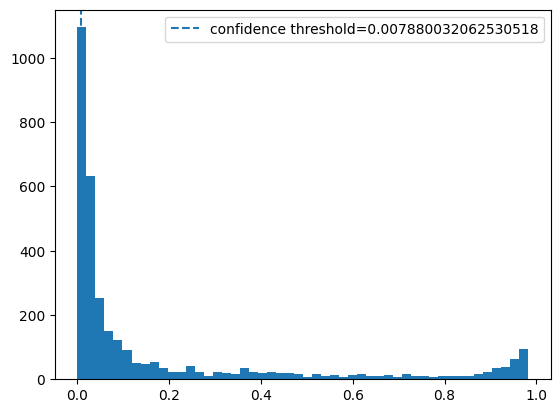

samples = 3342


0.007880032062530518

In [12]:
image_dir = "coco2017/val2017/"
ann_path = "coco2017/annotations/instances_val2017.json"

calib_model = OD_Calibrator(model = model, processor = processor, device = "cuda")
calib_model.conformal_calibrate(ann_path = ann_path, image_dir = image_dir, alpha = 0.10, batch_sz = 256, n_images = 100, iou_thresh = 0.50)

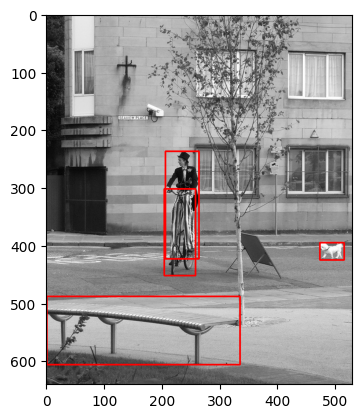

array([[[ 39,  39,  39],
        [ 25,  25,  25],
        [ 21,  21,  21],
        ...,
        [184, 184, 184],
        [186, 186, 186],
        [187, 187, 187]],

       [[ 36,  36,  36],
        [ 36,  36,  36],
        [ 31,  31,  31],
        ...,
        [178, 178, 178],
        [178, 178, 178],
        [179, 179, 179]],

       [[ 18,  18,  18],
        [ 25,  25,  25],
        [ 26,  26,  26],
        ...,
        [187, 187, 187],
        [187, 187, 187],
        [186, 186, 186]],

       ...,

       [[ 34,  34,  34],
        [ 32,  32,  32],
        [ 37,  37,  37],
        ...,
        [161, 161, 161],
        [157, 157, 157],
        [156, 156, 156]],

       [[ 32,  32,  32],
        [ 38,  38,  38],
        [ 43,  43,  43],
        ...,
        [111, 111, 111],
        [138, 138, 138],
        [150, 150, 150]],

       [[ 37,  37,  37],
        [ 42,  42,  42],
        [ 39,  39,  39],
        ...,
        [140, 140, 140],
        [134, 134, 134],
        [120, 120, 120]]

In [190]:
image_dir = "coco2017/val2017/"
ann_path = "coco2017/annotations/instances_val2017.json"
parsed_ann = calibrator.parse_coco_ann(ann_path)
image_id = list(parsed_ann.keys())[0]
image_path = image_dir + image_id + ".jpg"
image = np.array(Image.open(image_path))   

class_set, probs_set, bbox_preds =  calibrator.predict(image, max_set_size = 3)
calib_model.plot_objects(image, bbox = bbox_preds, object_class = class_set)

In [13]:
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Enable streams
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# Start streaming
pipeline.start(config)

try:
    i = 0
    while True:
        # Wait for a coherent pair of frames
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        depth_frame = frames.get_depth_frame()
        if not color_frame or not depth_frame:
            continue

        # Convert images to numpy arrays
        color_image = np.asanyarray(color_frame.get_data())
        #color_image_ = cv2.resize(color_image, (32, 32))

        #if i%4 == 0:
        preds_set, probs_set, bbox_set = calib_model.predict(image = color_image, max_set_size = 5)
        color_image = calib_model.plot_objects(image = color_image, bbox = bbox_set, object_class = preds_set, display = False) 

        #text = f"class set:{preds_set[0].tolist()}"
        #font = cv2.FONT_HERSHEY_SIMPLEX
        #font_scale = 1
        #color = (255, 0, 0)   # Blue in BGR
        #thickness = 2

        # Get image shape
        #(h, w) = color_image.shape[:2]

        # Get text size
        #(text_w, text_h), baseline = cv2.getTextSize(text, font, font_scale, thickness)

        # Position for top-right corner
        #x = w - text_w - 10   # 10 px from right border
        #y = text_h + 10       # 10 px from top

        # Draw text
        #cv2.putText(color_image, text, (x, y), font, font_scale, color, thickness)
        cv2.imshow('CP Example', color_image)
        if cv2.waitKey(1) & 0xFF == 27:  # ESC to quit
            break

        if i == 100: i = 0
        else: i += 1;
finally:
    pipeline.stop()
    cv2.destroyAllWindows()
